[*********************100%%**********************]  1 of 1 completed


Average of the Range: 282.3669906358615
                Open      High       Low     Close  Adj Close  Volume  \
Date                                                                    
2020-01-02   8776.75   8901.50   8769.50   8891.75    8891.75  416637   
2020-01-03   8895.50   8907.25   8735.25   8810.00    8810.00  599887   
2020-01-06   8772.25   8873.00   8723.00   8847.50    8847.50  469514   
2020-01-07   8853.25   8894.75   8825.75   8853.00    8853.00  510004   
2020-01-08   8841.50   8972.25   8678.00   8944.50    8944.50  723085   
...              ...       ...       ...       ...        ...     ...   
2023-12-22  16956.00  17041.50  16891.50  16980.00   16980.00  486853   
2023-12-26  16964.50  17111.25  16964.50  17083.50   17083.50  292090   
2023-12-27  17090.25  17133.00  17055.50  17113.25   17113.25  424302   
2023-12-28  17127.00  17165.25  17077.75  17090.50   17090.50  357702   
2023-12-29  17090.25  17131.00  16938.25  17023.50   17023.50  470864   

          

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-12-29   2023-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          91.45%       215.58%
CAGR﹪                     11.9%        22.01%

Sharpe                     0.73         1.87
Prob. Sharpe Ratio         92.71%       99.99%
Smart Sharpe               0.68         1.72
Sortino                    1.04         3.05
Smart Sortino              0.95         2.8
Sortino/√2                 0.73         2.15
Smart Sortino/√2           0.67         1.98
Omega                      1.4          1.4

Max Drawdown               -35.28%      -17.42%
Longest DD Days            754          178
Volatility (ann.)          27.21%       16.09%
R^2                        0.44         0.44
Information Ratio          0.02         0.02
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-17,2020-04-17,2020-09-02,170,-17.419477,-16.717834
2,2020-09-09,2020-11-05,2021-03-05,178,-10.333721,-9.364811
3,2020-02-03,2020-02-12,2020-02-26,24,-6.599823,-6.535280
4,2021-03-09,2021-04-05,2021-05-07,60,-6.018461,-5.986466
5,2021-10-05,2021-10-22,2021-11-09,36,-5.769934,-5.533607


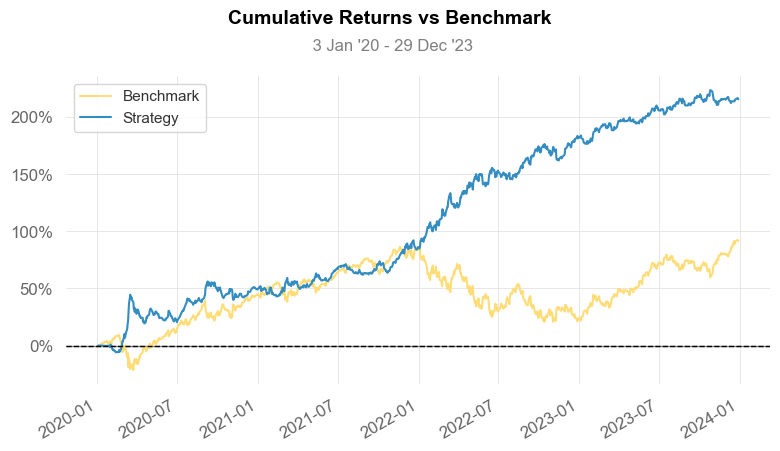

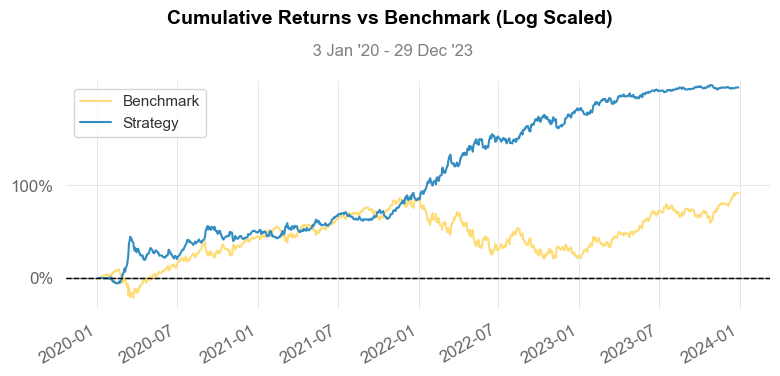

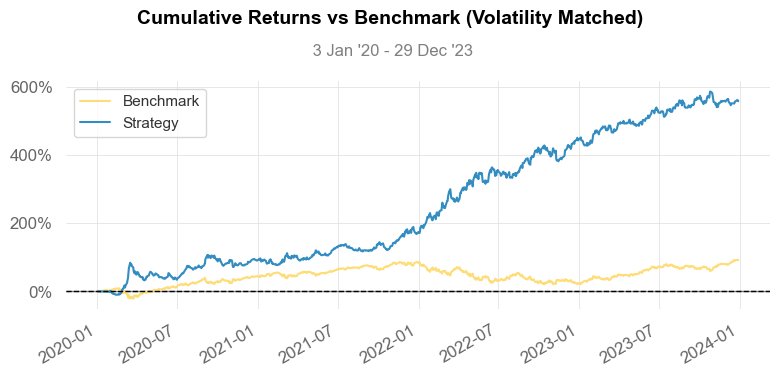

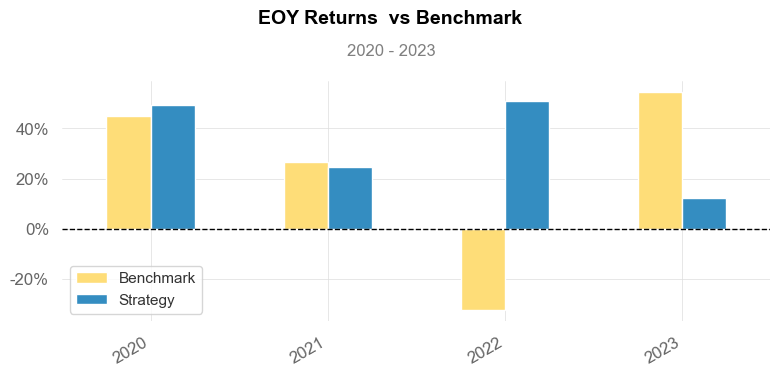

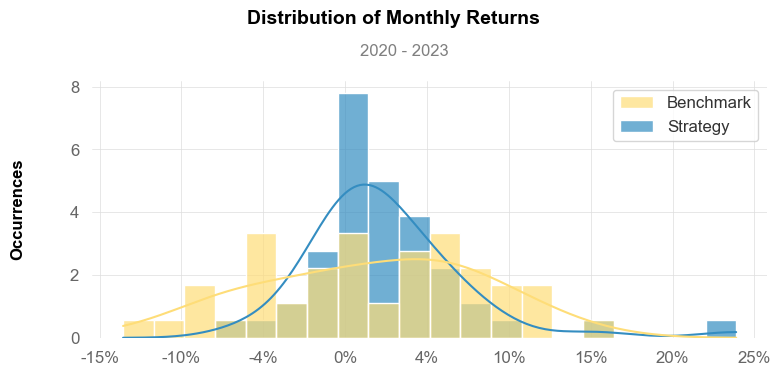

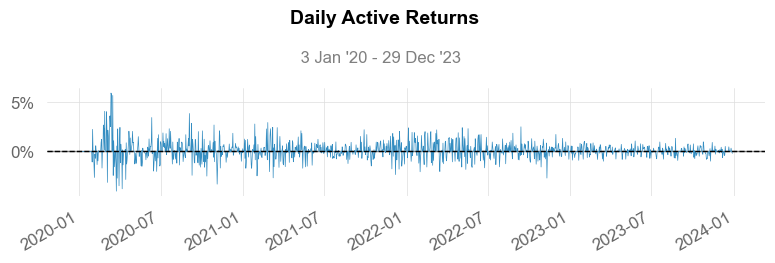

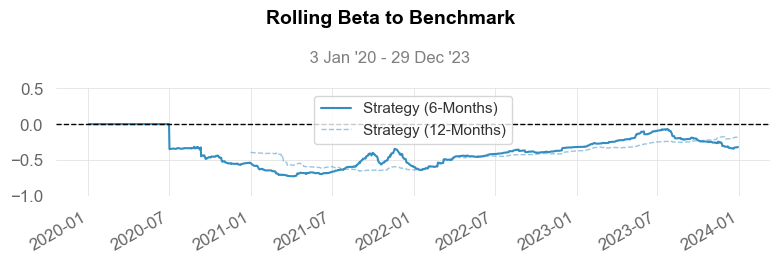

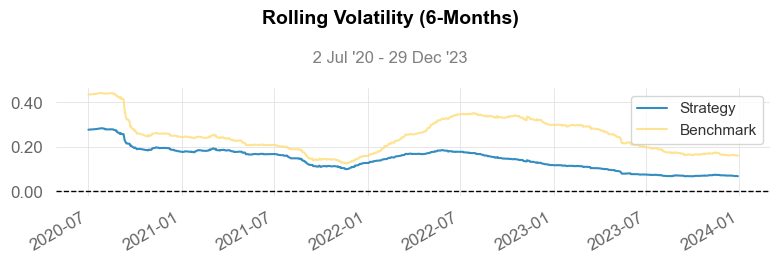

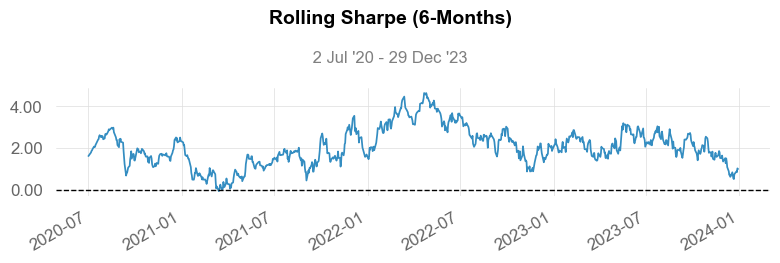

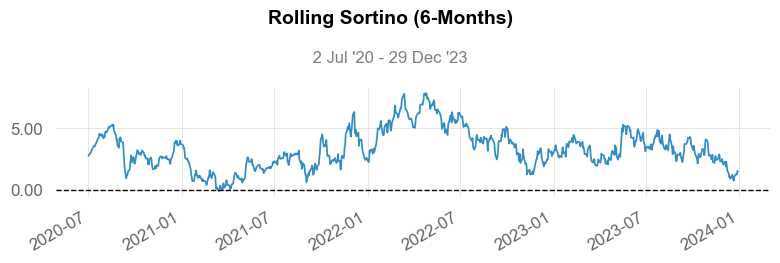

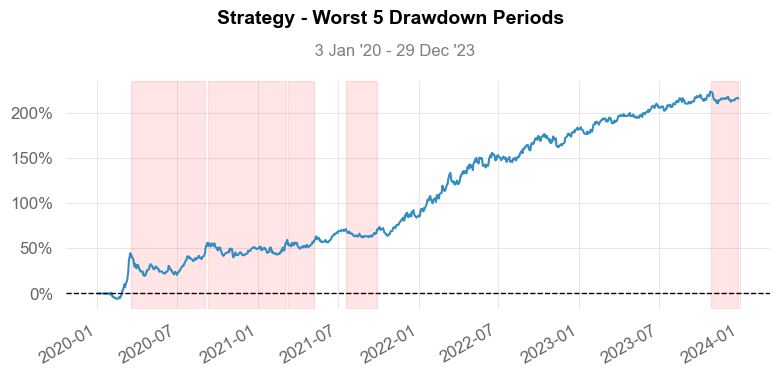

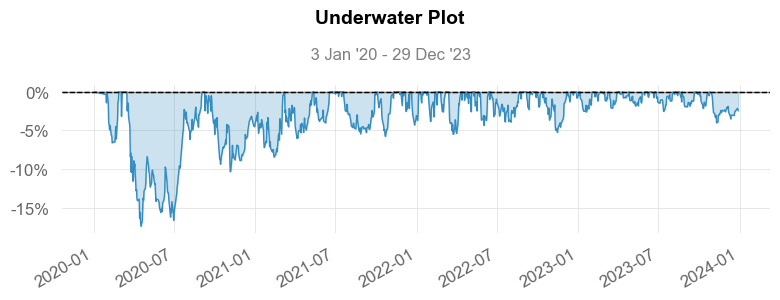

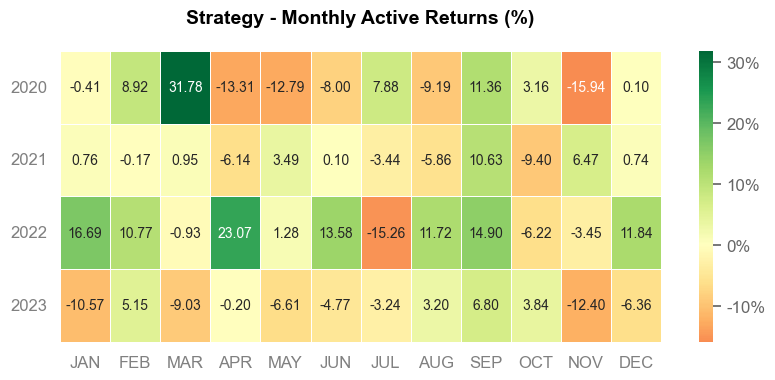

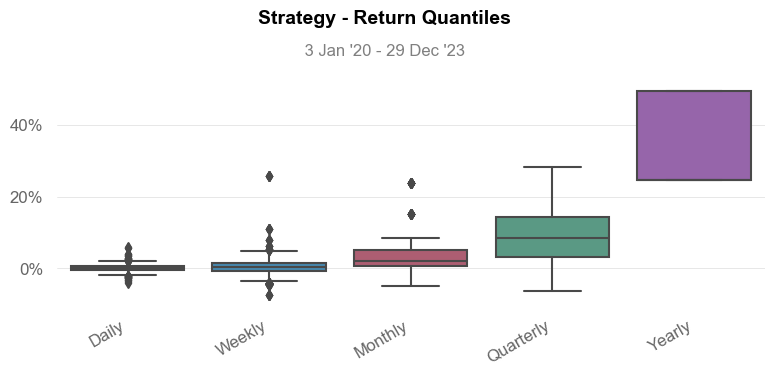

Total Profit: 25036.311386718742
Total Returns: 0.7145818548448379
Annualized Returns: 0.14472262986420348
Sharpe Ratio: 1.8685647200423676
Sortino Ratio: 3.043519207063549
Maximum Drawdown: -0.17419477215633627


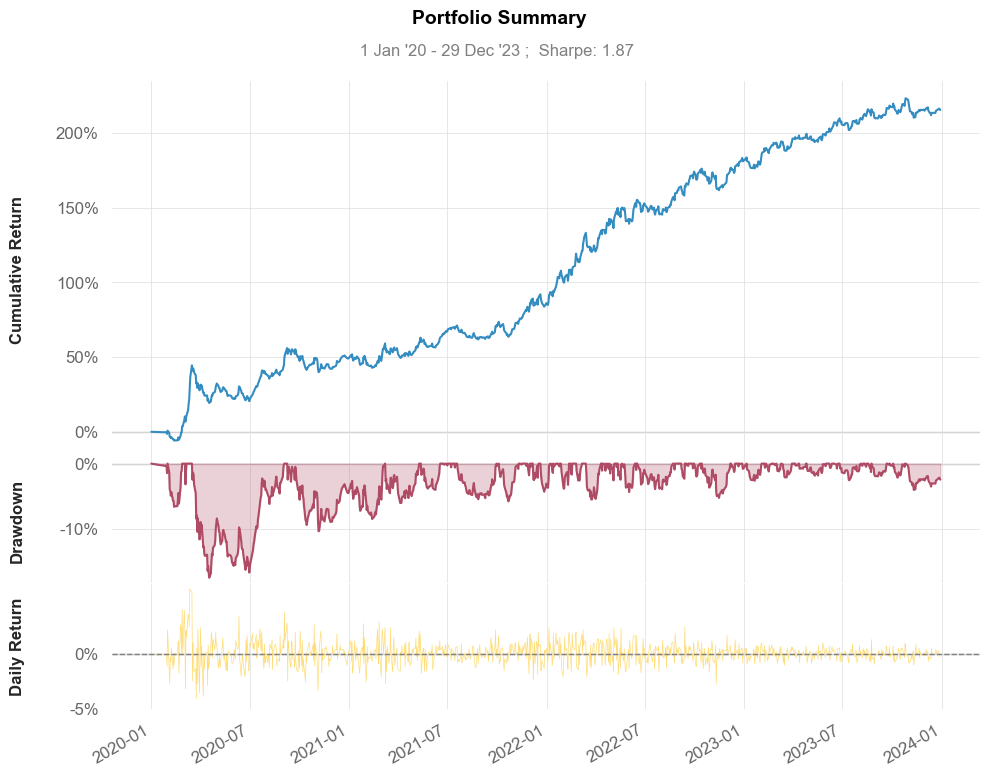

In [2]:
import yfinance as yf
import pandas as pd
import quantstats as qs
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Download historical data for NQ=F
ticker = 'NQ=F'
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, num_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['UpperBB'] = data['SMA'] + (data['STD'] * num_std)
    data['LowerBB'] = data['SMA'] - (data['STD'] * num_std)
    return data

data = calculate_bollinger_bands(data)

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

data = calculate_rsi(data)

# Backtest Strategy
def backtest_strategy(data):
    positions = []
    for i in range(len(data)):
        if data['Open'][i] >= data['LowerBB'][i] and data['RSI'][i] <= 70:
            positions.append('Sell')
        elif data['Open'][i] <= data['UpperBB'][i] and data['RSI'][i] >= 30:
            positions.append('Buy')
        else:
            positions.append('')
    data['Position'] = positions
    return data

data = backtest_strategy(data)

# Calculate Returns
#data['Returns'] = data['Close'].pct_change() if buy_signals, sell signals 

# Filter Trades
buy_signals = data[data['Position'] == 'Buy']
sell_signals = data[data['Position'] == 'Sell']
df = data 
# Show head of Data Dataframe 
#print(df.head(5))
#print(buy_signals.head(5))
#print(sell_signals.head(5))

df['Range']= df['High']-df['Low']

# What is the current average daily range from high to low on NQ Futures since Jan 2020? 
average = df['Range'].mean()
# Print the average value
print("Average of the Range:", average)
# Now we need to calculate Balance, Profit, and Returns columns for this dataframe and we are all set. 

# Points, Lots, Profit, Balance, Returns 
# Calculate Points
def calculate_points(data):
    points = []
    for i in range(len(data)):
        if data['Position'][i] == 'Buy':
            points.append(data['Close'][i] - data['Open'][i])
        elif data['Position'][i] == 'Sell':
            points.append(data['Open'][i] - data['Close'][i])
        else:
            points.append(0)
    data['Points'] = points
    return data

df = calculate_points(df)

# Define Lot Size
df['Lots']= 1

# Calculate commissions column

df['commissions'] = 1.98 * df['Lots']


# Define Profits 
df['Profit']= df['Points']*df['Lots']-df['commissions'].round(2)

# Initial Balance, Cumulative Profit, Balance

df['cumulative_profit'] = df['Profit'].cumsum()
data['Balance'] = 10000 + df['cumulative_profit'].round(2)

# Calculate 'returns' column
df['returns'] = df['Profit'] / df['Balance']

print(df)
#Quanstats#  Load returns, without having to convert to a series 
returns_series = df['returns']

benchmark = qs.utils.download_returns('NQ=F') # note ticker format 
qs.reports.full(returns_series , benchmark)
# Html Tearsheet3
#qs.reports.html(returns_series , benchmark=benchmark)
# Calculate total profit
total_profit = df['Profit'].sum()
print("Total Profit:", total_profit)

# Calculate total returns
total_returns = df['Profit'].sum() / df['Balance'].iloc[-1]
print("Total Returns:", total_returns)

# Calculate annualized returns
years = (df.index[-1] - df.index[0]).days / 365.25
annualized_returns = (1 + total_returns) ** (1 / years) - 1
print("Annualized Returns:", annualized_returns)

# Calculate Sharpe Ratio
sharpe_ratio = qs.stats.sharpe(returns_series)
print("Sharpe Ratio:", sharpe_ratio)

# Calculate Sortino Ratio
sortino_ratio = qs.stats.sortino(returns_series)
print("Sortino Ratio:", sortino_ratio)

# Maximum Drawdown
max_drawdown = qs.stats.max_drawdown(returns_series)
print("Maximum Drawdown:", max_drawdown)

# Plotting
qs.plots.snapshot(returns_series)

# Generate a full report including tearsheet
#qs.reports.full(returns_series, benchmark)

# If you want to save the report to HTML:
# qs.reports.html(returns_series, benchmark=benchmark, output='report.html')

import os

# Get the path to your desktop
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')

# Save the DataFrame as a CSV file on your desktop
#df.to_csv(os.path.join(desktop_path, 'bollidf.csv'), index=False)

#print("DataFrame 'df' has been saved as 'df.csv' on your desktop.")